# Extract and convert papers

In this notebook, we convert preprints from TEX to XML, a format that simplifies downstream parsing, using the [latexml](https://dlmf.nist.gov/LaTeXML/) package. 

We store converted XML files in `/data/xml/`.

Contents:
1. Setup
2. Extract and convert preprints
3. Get results
4. Appendix: Request a submission from arXiv API

## 1. Setup 

Import dependencies and globals:

In [5]:
import os, re, subprocess, glob, multiprocessing, time, tarfile, gzip, shutil, zipfile
import pandas as pd
import numpy as np
import pickle
import math
import requests

GLOBALS = pickle.load(open('../data/globals.p', 'rb'))
GLOBALS

{'absolute_filepaths': {'metadata': '/Volumes/ARCHIVES/Thesis/data/metadata.csv',
  'conversion_log': '/Volumes/ARCHIVES/Thesis/data/conversion_log.csv',
  'xml': '/Volumes/ARCHIVES/Thesis/data/xml/',
  'archive': '/Volumes/ARCHIVES/Thesis/data/archive/',
  'corpus': '/Volumes/ARCHIVES/Thesis/data/corpus/'},
 'start': 2009,
 'end': 2019}

Load conversion log and arXiv paper ids (from the metadata).

In [2]:
metadata = pd.read_csv(GLOBALS['absolute_filepaths']['metadata'], 
                       dtype={'filename': str, 
                              'filename_parsed': str,
                              'identifier': str,
                              'updated': str,
                              'doi': str,
                              'in_range': bool}, 
                       parse_dates=['date_retrieved'])

identifiers = list(metadata['filename_parsed'])

conversion_log = pd.read_csv(GLOBALS['absolute_filepaths']['conversion_log'],
                             dtype={'submission': str})

## 2. Extract and convert preprints

Check some stuff.

In [6]:
# Find from the metadata the number of papers that are in our desired time range
years = pd.to_datetime(metadata['created']).apply(lambda x: x.year)
papers_out_of_range = [i for i, isInRange in enumerate(years.apply(lambda x: x < GLOBALS['start'] or x > GLOBALS['end'])) if isInRange]
papers_in_range = list(metadata.drop(papers_out_of_range)['filename_parsed'])
fulltexts = [os.path.splitext(os.path.basename(x))[0] for x in os.listdir(GLOBALS['absolute_filepaths']['xml']) if x.endswith('.xml')]

print('We have metadata for ' + str(len(identifiers)) + ' papers. Not all are in our desired time range.')
print('Number of papers in our desired time range: ' + str(len(papers_in_range)))
print('Current status of extraction and conversion...')
print('\tAttempted: ' + str(len(conversion_log)))
print('\tSuccessful: ' + str(len(fulltexts)))
print('\tRemaining: ' + str(len(papers_in_range) - len(conversion_log)))

We have metadata for 274402 papers. Not all are in our desired time range.
Number of papers in our desired time range: 159625
Current status of extraction and conversion...
	Attempted: 159625
	Successful: 145437
	Remaining: 0


**Run cells below if there are papers remaining to be extracted and converted.**

In [46]:
tasks = [GLOBALS['absolute_filepaths']['archive'] + x for x in os.listdir(GLOBALS['absolute_filepaths']['archive']) if x.endswith('.tar')]
print('Tars/tasks to process: ' + str(len(tasks)))
extraction_path = '../data/temp_extractions/'
csv = '../data/temp_log.csv' # name differently in each notebook
chunks = np.array_split(tasks, 3) # do this in each notebook if running multiple notebooks to speed up this process

Tars/tasks to process: 5


In [35]:
def get_outpath(submission_path):
    '''
    Returns the filepath for a XML file, based on the given filepath. 
    '''
    submission_id = os.path.splitext(os.path.basename(submission_path))[0]
    outpath = GLOBALS['absolute_filepaths']['xml'] + submission_id + '.xml'
    return outpath

def open_tar(tar_file):
    if os.path.isfile(tar_file) and tarfile.is_tarfile(tar_file):
        tar = tarfile.open(tar_file)
        tar_name = os.path.splitext(os.path.basename(tar.name))[0]
        return tar, tar_name 
    else:
        return None, None


def extract(tar, submission, extracted_gz_path):
    '''
    Extracts given submission (formatted as TarInfo object).
    Returns string signifying whether or not extraction was successful.
    '''
    try:
        suffix = '.zip'
        gz_obj = tar.extractfile(submission)
        gz = tarfile.open(fileobj=gz_obj, mode='r|gz')
        zipf = zipfile.ZipFile(file=extracted_gz_path + suffix, mode='a', compression=zipfile.ZIP_DEFLATED)

        for m in gz:
            f = gz.extractfile(m)
            if m.isdir():
                continue
            f_out = f.read()
            f_in = m.name
            zipf.writestr(f_in, f_out)
        zipf.close()
        gz.close()
        extracted = 'yes'
    except tarfile.ReadError: 
        # These submissions contain a single .tex file with no extension,
        # so we need to treat them differently
        suffix = '.tex'
        tar.extract(submission, extraction_path)
        with gzip.open(extraction_path + submission.name, 'rb') as f_in:
            with open(extraction_path + submission.name + suffix, 'wb+') as f_out:
                shutil.copyfileobj(f_in, f_out)
        extracted = 'yes'
        
    return extracted, suffix


def do_not_convert(submission_id):
    '''
    Returns boolean indicating whether or not the given submission should be converted.
    We only want submissions that are from the astrophysics archive, and, for performance
    purposes, that haven't already been converted.
    '''
    not_astrophysics = submission_id not in identifiers
    already_converted = submission_id in conversion_log['submission'].values
    out_of_range = not metadata[metadata['filename_parsed'] == submission_id]['in_range'].iloc[0]
    # submission_id not in papers_in_range
    return not_astrophysics or already_converted or out_of_range

        
def convert(submission_path):
    '''
    Converts file at passed filepath to XML, using LaTeXMLc.
    '''
    outpath = get_outpath(submission_path)
    print('Converting to ' + outpath)
    try:
        proc = subprocess.Popen(['latexmlc', '--timeout=240', '--dest=' + outpath, submission_path], stderr=subprocess.PIPE)
        out, err = proc.communicate()
        err = err.decode('utf-8')
        # Check if file was converted successfully
        if 'Error! Did not write file' in err:
            converted = 'no'
        else:
            converted = 'yes'
    except Exception as e:
        print('Something went wrong in convert(): ' + str(e))
        converted = 'no'
    return err, converted

def save_log(log):
    # Save log so we have something if it fails
    df = pd.DataFrame(log, columns=['submission', 
                            'tarfile', 
                            'type', 
                            'extracted', 
                            'extracted_suffix',
                            'converted',
                            'conversion_result'])
    
    df.to_csv(csv, mode='a', header=(not os.path.exists(csv)), index=False)
    
def work(task):
    '''
    Defines work to be done for each tar.
    task — filepath to tar
    '''
    # Open it as read-only 
    log = []
    tar, tar_name = open_tar(task)
    if tar_name == None: 
        return
    print('\nOpening ' + tar_name + ',')
    extracted_tar_path = None # temp, only for ReadErrors, will know path once we get tar contents

    # For each submission (.gz or .pdf)
    for submission in tar.getmembers():
        if submission.name.endswith('.gz') or submission.name.endswith('.pdf'):
            submission_id = os.path.splitext(os.path.basename(submission.name))[0]
            if do_not_convert(submission_id):
                print('Not converting ' + submission_id)
                continue
            print('Working on submission: ' + submission_id + '...')
            submission_path = os.path.splitext(task)[0] + '/' + submission_id
            submission_type = os.path.splitext(os.path.basename(submission.name))[1]

            # If .pdf, skip, we cannot extract and will not convert here
            if submission_type == '.pdf':
                result = None
                extracted = 'no'
                converted = 'no'
                suffix = '' # WILL NEED TO GO BACK THROUGH AND FIX BECAUSE I ADDED THIS LATE (fixed)
            else:
                # Extract submission 
                #extracted_gz_path = '../data/2020_03_09_extract_and_convert_submissions/temp_extractions/'
                extracted_tar_path = extraction_path + submission.name.split('/')[0] + '/'
                #print('Extracted gz path: ' + extracted_gz_path)
                #print('Extracted tar path: ' + extracted_tar_path)
                extracted, suffix = extract(tar, submission, extraction_path + submission_id)

                print('Extracted: ' + extracted + ' ' + suffix)
                # Convert submission and remove extracted submission
                if extracted == 'yes':
                    result, converted = convert(extraction_path + submission_id + suffix)
                
                print('Converted: ' + converted)
                # Remove the folder that appears for the tar during ReadErrors, if it exists
                if os.path.exists(extracted_tar_path): 
                    shutil.rmtree(extracted_tar_path)
                else:
                    os.remove(extraction_path + submission_id + suffix)

            # Log submission extraction & conversion info, remove .zip
            log.append([submission_id, tar_name, submission_type, extracted, suffix, converted, result])

    save_log(log)

    # After finishing tarfile, move it to 'processed' directory
    os.rename(task, os.path.dirname(task) + '/extracted/' + tar_name + '.tar')

In [48]:
#for task in chunks[2]: # run if we had to split many tars into chunks
#    work(task)
    
for task in tasks: # run if we only have a few tars left to process
    work(task)

Consolidate log files (from multiple notebooks and older log file) and check the resulting log to make sure it looks ok.

In [77]:
log1 = pd.read_csv('../data/temp_log.csv', dtype={'submission': str})
log2 = pd.read_csv('../data/temp_log2.csv', dtype={'submission': str})
log3 = pd.read_csv('../data/temp_log3.csv', dtype={'submission': str})
log = pd.concat([conversion_log, log1, log2, log3], axis=0, sort=True, ignore_index=True)
log

Save log.

In [300]:
log.to_csv(GLOBALS['absolute_filepaths']['conversion_log'], index=False)

## 3. Get results

Load conversion log.

In [7]:
results = pd.read_csv(GLOBALS['absolute_filepaths']['conversion_log'],
                      dtype={'submission': str})
results

,conversion_result,converted,extracted,extracted_suffix,submission,tarfile,type
0,\n(Loading /opt/local/lib/perl5/vendor_perl/5....,yes,yes,.zip,1702.07719,arXiv_src_1702_018,.gz
1,\n(Loading /opt/local/lib/perl5/vendor_perl/5....,yes,yes,.zip,1702.07818,arXiv_src_1702_018,.gz
2,\n(Loading /opt/local/lib/perl5/vendor_perl/5....,yes,yes,.zip,1702.07907,arXiv_src_1702_018,.gz
3,\n(Loading /opt/local/lib/perl5/vendor_perl/5....,yes,yes,.zip,1702.07768,arXiv_src_1702_018,.gz
4,NaN,no,no,.zip,1702.07796,arXiv_src_1702_018,.pdf
...,...,...,...,...,...,...,...
159620,NaN,no,no,NaN,1912.10618,NaN,.pdf
159621,\n(Loading /opt/local/lib/perl5/vendor_perl/5....,yes,yes,.zip,1912.10621,NaN,.gz
159622,NaN,no,no,NaN,1912.10622,NaN,.pdf
159623,\n(Loading /opt/local/lib/perl5/vendor_perl/5....,yes,yes,.zip,1912.10623,NaN,.gz


What were the file formats of those files that did not get extracted?

In [8]:
results[results['extracted'] == 'no']['type'].value_counts()

.pdf    6728
.gz        6
Name: type, dtype: int64

Which files were extracted but did not get converted correctly?

In [181]:
conversion_failed = results[(results['converted'] == 'no') & (results['extracted'] == 'yes')]['submission']
conversion_failed

16        1702.07636
103       1707.03458
143        1409.3352
178        1409.3004
256       1707.04266
             ...    
159478     1312.7590
159479     1312.7790
159487     1401.1370
159488     1401.1230
159499     1401.1630
Name: submission, Length: 7453, dtype: object

In [187]:
results.to_csv(GLOBALS['absolute_filepaths']['conversion_log'], index=False)

Ensure that we have a record for every XML we have.

In [62]:
len(results[results['submission'].apply(lambda x: x in xmls)]) == len(xmls)

True

Ensure that all of our files in conversion log are in range.

Series([], Name: in_range, dtype: bool)

Find out which files failed and need to be put aside from abstracts. 

In [188]:
xmls = [os.path.splitext(os.path.basename(x))[0] for x in os.listdir(GLOBALS['absolute_filepaths']['xml']) if x.endswith('.xml')]
eligible_papers = metadata[metadata['in_range']]
converted_metadata = metadata[metadata['filename_parsed'].isin(xmls)]

print('Papers eligible for our corpus: ' + str(len(eligible_papers)))
print('Papers we have logged: ' + str(len(results)))

print('\nPapers extracted and converted: ' + str(len(xmls)))
print('We have logs for all papers we extracted and converted: ' + str(set(xmls) - set(results['submission']) == set()))
print('They were all eligible for our corpus: ' + str(converted_metadata['in_range'].value_counts()[True] == len(xmls)))

missing_papers = len(eligible_papers) - len(xmls)
print('\nMissing: ' + str(missing_papers))
eligible_papers_missing_from_log = len(eligible_papers) - len(results)
print('Eligible papers missing from log: ' + str(eligible_papers_missing_from_log))
papers_not_extracted = results['extracted'].value_counts()['no']
print('Papers we failed to extract: ' + str(papers_not_extracted))
papers_extracted_but_not_converted = results[(results['extracted'] == 'yes') & (results['converted'] == 'no')]
print('Papers we extracted but failed to convert: ' + str(len(papers_extracted_but_not_converted)))
total_failed_papers = eligible_papers_missing_from_log + papers_not_extracted + len(papers_extracted_but_not_converted)
print('The above 3 numbers total the number of missing papers: ' + str(missing_papers == total_failed_papers))

print('\nOf the papers that we failed to extract...')
types = results[results['extracted'] == 'no']['type'].value_counts()
print('Number of PDFs: ' + str(types['.pdf']))
print('Number of zipped files: ' + str(types['.gz']))

Papers eligible for our corpus: 159625
Papers we have logged: 159625

Papers extracted and converted: 145437
We have logs for all papers we extracted and converted: True
They were all eligible for our corpus: True

Missing: 14188
Eligible papers missing from log: 0
Papers we failed to extract: 6734
Papers we extracted but failed to convert: 7454
The above 3 numbers total the number of missing papers: True

Of the papers that we failed to extract...

Number of PDFs: 6728

Number of zipped files: 6


In [187]:
type(results[results['extracted'] == 'no']['type'].value_counts()['.pdf'])

numpy.int64

Most of the papers we failed to extract are pdfs. 

All of the papers that we extracted but failed to convert are not worth trying to fix right now. 

So we have lost 14,177 papers through the extraction and conversion process. If we could parse PDFs we would save ~6,000 with this. But we have enough. We just need to note that these papers do not `has_xml` in the metadata.

Request the 111 missing papers individually.

In [33]:
import gzip
import shutil

def extract_gz(filename):
    extracted = 'no'
    prefix = filename.split('.tar.gz')[0]
    
    try:
        suffix = '.zip'
        gz = tarfile.open(name=filename, mode='r|gz')
        zipf = zipfile.ZipFile(file=prefix + suffix, mode='a', compression=zipfile.ZIP_DEFLATED)
        for m in gz:
            f = gz.extractfile(m)
            if m.isdir():
                continue
            f_out = f.read()
            f_in = m.name
            zipf.writestr(f_in, f_out)
        zipf.close()
        extracted = 'yes'
    except tarfile.ReadError: 
        # These submissions contain a single .tex file with no extension,
        # so we need to treat them differently
        suffix = '.tex'
        with gzip.open(prefix + suffix, 'rb') as f_in:
            with open(extraction_path + submission.name + suffix, 'wb+') as f_out:
                shutil.copyfileobj(f_in, f_out)
        extracted = 'yes'
        
    return extracted, suffix

In [31]:
filename = '../data/temp_extractions/1709.03058.tex'
filename.split('.tex')[0]

'../data/temp_extractions/1709.03058'

In [36]:
papers_to_request = eligible_papers[~eligible_papers['filename_parsed'].isin(results['submission'])]['filename_parsed']
log = []

for paper_id in papers_to_request:
    filename = download_source_file(paper_id)
    
    submission_type = os.path.splitext(os.path.basename(filename))[1]
    
    if submission_type == '.pdf':
        result = None
        extracted = 'no'
        converted = 'no'
        suffix = None 
    elif submission_type == '.tex':
        prefix = filename.split('.tex')[0]
        result, converted = convert(prefix + suffix)
    else:
        extracted, suffix = extract_gz(filename)
        prefix = filename.split('.tar.gz')[0]
        result, converted = convert(prefix + suffix)
        
    log.append([paper_id, None, submission_type, extracted, suffix, converted, result])

Created 1709.02729.tar.gz
Converting to /Volumes/ARCHIVES/Thesis/data/xml/1709.02729.xml
Created 1709.02734.tar.gz


/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'an.cls'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'B-t.eps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'dB-t.eps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'Gao-2017-3.tex'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'graphicx.sty'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'index.eps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3

Converting to /Volumes/ARCHIVES/Thesis/data/xml/1709.02734.xml
Created 1709.02754.tar.gz
Converting to /Volumes/ARCHIVES/Thesis/data/xml/1709.02754.xml


/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'gws_MS1i0th60ph90.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'main.bbl'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'main.tex'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'peak_cont_i0.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'peak_cont_i30.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'r_ms_r_i0.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/brie

Created 1709.02757.tar.gz
Converting to /Volumes/ARCHIVES/Thesis/data/xml/1709.02757.xml


/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'fig1.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'fig2.png'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'fig3.png'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'fig4.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'fig5.png'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'fig6.png'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfi

Created 1709.02763.pdf
Created 1709.02774.tar.gz
Converting to /Volumes/ARCHIVES/Thesis/data/xml/1709.02774.xml


/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'fig10.eps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'fig1.eps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'fig2.eps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'fig3.eps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'fig4.eps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'fig5.eps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipf

Created 1709.02775.tar.gz


/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'burst_dete_lc_v3.eps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'burst_lc_1s_v3.eps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'chart_coord_v4.eps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'igr17445_eng2.tex'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'jmxspec_v1.eps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'pazha2.cls'
  return self._open_to_write(zinfo, force_zip64=force_zip6

Converting to /Volumes/ARCHIVES/Thesis/data/xml/1709.02775.xml
Created 1709.02784.tar.gz
Converting to /Volumes/ARCHIVES/Thesis/data/xml/1709.02784.xml


/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'bestplot.png'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'compactinviscid.png'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'compactviscid.png'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'extendedinviscid.png'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'extendedviscid.png'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'f1lnew.png'
  return self._open_to_write(zinfo, force_zip64=force_zip64

Created 1709.02787.tar.gz
Converting to /Volumes/ARCHIVES/Thesis/data/xml/1709.02787.xml


/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'figures_ext/bauswein.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'figures_ext/bauswein.pdf.bb'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'figures_ext/eos2-M-R.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'figures_ext/eos2-M-R.pdf.bb'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'figures_ext/universal-other-eos-J-M0.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'figures_ext/uni

Created 1709.02791.tar.gz


/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'April_jets_editorial_corrections.tex'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'fig10.ps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'fig11.ps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'fig12.ps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'fig13.ps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'fig14.ps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/a

Converting to /Volumes/ARCHIVES/Thesis/data/xml/1709.02791.xml
Created 1709.02796.tar.gz
Converting to /Volumes/ARCHIVES/Thesis/data/xml/1709.02796.xml


/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'aa.bst'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'aa.cls'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'a.txt'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'ForecastingSunspots25.bbl'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'ForecastingSunspots25.out'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'ForecastingSunspots25.tex'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/U

Created 1709.02799.tar.gz


/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'aastex.cls'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'apj.bst'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'emulateapj.cls'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'Graficos/mmax.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'Graficos/correlations50.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'Graficos/comp1.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/

Converting to /Volumes/ARCHIVES/Thesis/data/xml/1709.02799.xml
Created 1709.02807.tar.gz
Converting to /Volumes/ARCHIVES/Thesis/data/xml/1709.02807.xml


/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'APOGEE-Hercules.bbl'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'APOGEE-Hercules.tex'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'FullHist.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'Hist2.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'KDEfit.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'mn2e.bst'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/

Created 1709.02809.tar.gz


/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'aastex.cls'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'CI_GRH10.eps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'CI_GRH11.eps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'CI_GRH1.eps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'CI_GRH2.eps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'CI_GRH3.eps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/

Converting to /Volumes/ARCHIVES/Thesis/data/xml/1709.02809.xml
Created 1709.02811.tar.gz
Converting to /Volumes/ARCHIVES/Thesis/data/xml/1709.02811.xml


/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'BibTeX/iopart-num/iopart-num.bst'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'BibTeX/iopart-num/iopart-num.tex'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'BibTeX/iopart-num/README'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'iopams.sty'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'jpconf11.clo'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'jpconf.cls'
  return self._open_to_write(zinfo,

Created 1709.02815.tar.gz
Converting to /Volumes/ARCHIVES/Thesis/data/xml/1709.02815.xml


/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'amax_r_wfits.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'chisquare.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'compositions_opacities_abs.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'compositions_opacities.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'compositions_opacities_sca.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'compositions_rotVel.pdf'
  return self._op

Created 1709.02816.tar.gz
Converting to /Volumes/ARCHIVES/Thesis/data/xml/1709.02816.xml


/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: '0050ns_0200pul_all_minfbin1.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'a0-b0-plane-SKA.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'BibDef.sty'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'bibnote.bib_'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'boxedminipage.sty'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'burst.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip

Created 1709.02818.tar.gz
Converting to /Volumes/ARCHIVES/Thesis/data/xml/1709.02818.xml


/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'RecISOAB2.eps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'RecISOAB.eps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'RecISOmup2.eps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'RecISOmup.eps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'RecISOw2.eps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'RecISOw.eps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/an

Created 1709.02824.tar.gz
Converting to /Volumes/ARCHIVES/Thesis/data/xml/1709.02824.xml


/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'counts.eps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'crosspowers.eps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'ms_c17_rev_resub.tex'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'xray_broad.eps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'xray_multi_ab.eps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'xray_multi.eps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)


Created 1709.02826.tar.gz
Converting to /Volumes/ARCHIVES/Thesis/data/xml/1709.02826.xml


/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'cartwheel.bbl'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'cartwheel.tex'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'fig_azimuth.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'fig_com.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'fig_compressivefraction.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'fig_compressivetrigger.pdf'
  return self._open_to_write(zinfo, force_zip64=fo

Created 1709.02830.tar.gz
Converting to /Volumes/ARCHIVES/Thesis/data/xml/1709.02830.xml


/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'lightcurve.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'lightcurve.png'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'PoS.cls'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'PoSlogo.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'PoSlogo.ps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'PoStemplate.odt'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anacon

Created 1709.02834.tar.gz
Converting to /Volumes/ARCHIVES/Thesis/data/xml/1709.02834.xml


/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'ms.bbl'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'ms.tex'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'mydefinitions.tex'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'Ppsi0.5.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'Ppsi0.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'Ppsi1.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/pytho

Created 1709.02845.tar.gz


/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'AGN4_energy.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'AGN4_zoom.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'AGNB2_energy.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'AGNB2_vertical_plot.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'AGNB2_zoom.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'AGNBM1_profile3.pdf'
  return self._open_to_write(zinfo, force_zip64=force_z

Converting to /Volumes/ARCHIVES/Thesis/data/xml/1709.02845.xml
Created 1709.02859.tar.gz
Converting to /Volumes/ARCHIVES/Thesis/data/xml/1709.02859.xml


/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'aas_macros.sty'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'comparison_end_box.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'comparison_end_fourier.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'IFD.bbl'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'IFD.tex'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'resolution_comparison_end_box.pdf'
  return self._open_to_write(zinfo, force_zip6

Created 1709.02861.tar.gz
Converting to /Volumes/ARCHIVES/Thesis/data/xml/1709.02861.xml


/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'apjfonts.sty'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'emulateapj.cls'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'f10.eps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'f1a.eps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'f1b.eps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'f2.eps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/

Created 1709.02882.tar.gz


/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'apj.bst'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'emulateapj.cls'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'Figure1a_rev2.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'Figure1b_rev2.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'Figure2_rev2.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'Figure3_rev2.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/

Converting to /Volumes/ARCHIVES/Thesis/data/xml/1709.02882.xml
Created 1709.02903.tar.gz


/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'aastex61.cls'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'cartoon_model_v5.eps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'h2co_spec_2panels.eps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'h2o.eps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'isotope_overlapp.eps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'LT_Variability_paper_2017-09-08.tex'
  return self._open_to_write(zinfo, forc

Converting to /Volumes/ARCHIVES/Thesis/data/xml/1709.02903.xml
Created 1709.02915.tar.gz


/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: '1851_2drr.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'CMD_5.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'CMD_env_2.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'CMD_ISO_1.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'CMD_MC_5.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'CMPL3.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda

Converting to /Volumes/ARCHIVES/Thesis/data/xml/1709.02915.xml
Created 1709.02923.tar.gz


/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'figure01a.eps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'figure01b.eps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'figure01c.eps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'figure01d.eps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'figure02.eps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'figure03a.eps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/

Converting to /Volumes/ARCHIVES/Thesis/data/xml/1709.02923.xml
Created 1709.02961.tar.gz


/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'Figure10.eps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'Figure11.eps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'Figure12.eps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'Figure13.eps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'Figure14.eps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'Figure1.eps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anacon

Converting to /Volumes/ARCHIVES/Thesis/data/xml/1709.02961.xml
Created 1709.02986.tar.gz
Converting to /Volumes/ARCHIVES/Thesis/data/xml/1709.02986.xml


/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'consttoslow.tex'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'plot1.eps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'plot2.eps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'plot3.eps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'plot4.eps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)


Created 1709.03001.tar.gz


/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: '87LiBaWr.PS.eps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'final.tex'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'PO_CDMS.eps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'PO_DMC.eps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'PO_obs-calc.eps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'PO_PECs.eps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anacon

Converting to /Volumes/ARCHIVES/Thesis/data/xml/1709.03001.xml
Created 1709.03054.tar.gz


/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'figs/magneticbraking.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'figs/model_comparison_10000Myr.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'figs/model_comparison_125Myr.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'figs/model_comparison_13Myr.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'figs/model_comparison_150Myr.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'figs

Converting to /Volumes/ARCHIVES/Thesis/data/xml/1709.03054.xml
Created 1709.03057.tar.gz


/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'aas_macros.sty'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'Covariance.bbl'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'Covariance.tex'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'Figure1.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'Figure2.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'Figure3_bottom_left.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/

Converting to /Volumes/ARCHIVES/Thesis/data/xml/1709.03057.xml
Created 1709.03058.tar.gz


/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'asymmetry_x.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'decayrate.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'exposure.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'feyndiag.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'main3a.bbl'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'main3a.tex'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaco

Converting to /Volumes/ARCHIVES/Thesis/data/xml/1709.03058.xml
Created 1709.03078.pdf
Created 1709.03081.pdf
Created 1709.03083.tar.gz


/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'aa.bst'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'aa.cls'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'CoG_H132800_FE1_cr.ps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'CoG_H132800_FE2_cr.ps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'CoG_H132801_FE1_cr.ps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'CoG_H132801_FE2_cr.ps'
  return self._open_to_write(zinfo, force_zip64=force_zip64

/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'NGC1866_morelines_corr.eps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'NGC1866_XH_morelines.eps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'SMC_cep.ps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'spec_5317_5347.ps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'subfloat.sty'
  return self._open_to_write(zinfo, force_zip64=force_zip64)


Converting to /Volumes/ARCHIVES/Thesis/data/xml/1709.03083.xml
Created 1709.03091.tar.gz


/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: '0055-328_X_AD_taper.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: '0055-328_X_L.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: '0144-522_X_E.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: '0227-369_X_L.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: '0235-618_X_X.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: '0244-470_X_L.pdf'
  return self._open_to_write(zinfo, force_zip64=forc

Converting to /Volumes/ARCHIVES/Thesis/data/xml/1709.03091.xml
Created 1709.03095.tar.gz
Converting to /Volumes/ARCHIVES/Thesis/data/xml/1709.03095.xml


/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'figures/Boxing-Day-SEOBNRv3-Source-IMRPv2-Template-M1XI1.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'figures/Boxing-Day-SEOBNRv3-Source-IMRPv2-Template-MXI.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'figures/Boxing-Day-SEOBNRv3-Source-IMRPv2-Template-QXI.pdf'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'figures/EOBNRv2HM_vs_IMRPhenomD-SEOBNRv4_overlaps.png'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'figures/fig-mma-VolumetricCompare-Chi1Chi2-Synthetic-GW151226.pdf'
  return sel

Created 1709.03103.tar.gz
Converting to /Volumes/ARCHIVES/Thesis/data/xml/1709.03103.xml


/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'chameleons.bbl'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'chameleons.tex'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'dmm_xu.eps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'experimental.eps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'HFS.eps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/briennakh/anaconda3/lib/python3.6/zipfile.py:1355: UserWarning: Duplicate name: 'L1498-1-ch3oh-chi2.ps'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/Users/brien

Created 1709.03108.tex
Converting to /Volumes/ARCHIVES/Thesis/data/xml/1709.03108.xml
Created 1709.03118.tar.gz
Converting to /Volumes/ARCHIVES/Thesis/data/xml/1709.03118.xml
Created 1709.03119.tar.gz
Converting to /Volumes/ARCHIVES/Thesis/data/xml/1709.03119.xml
Created 1912.05926.tar.gz
Converting to /Volumes/ARCHIVES/Thesis/data/xml/1912.05926.xml
Created 1912.05927.tar.gz
Converting to /Volumes/ARCHIVES/Thesis/data/xml/1912.05927.xml
Created 1912.05953.tar.gz
Converting to /Volumes/ARCHIVES/Thesis/data/xml/1912.05953.xml
Created 1912.05969.tar.gz
Converting to /Volumes/ARCHIVES/Thesis/data/xml/1912.05969.xml
Created 1912.05976.tar.gz
Converting to /Volumes/ARCHIVES/Thesis/data/xml/1912.05976.xml
Created 1912.05980.tar.gz
Converting to /Volumes/ARCHIVES/Thesis/data/xml/1912.05980.xml
Created 1912.05986.tar.gz
Converting to /Volumes/ARCHIVES/Thesis/data/xml/1912.05986.xml
Created 1912.05995.tar.gz
Converting to /Volumes/ARCHIVES/Thesis/data/xml/1912.05995.xml
Created 1912.06002.tar.g

In [37]:
log_df = pd.DataFrame(log, columns=['submission', 
                        'tarfile', 
                        'type', 
                        'extracted', 
                        'extracted_suffix',
                        'converted',
                        'conversion_result'])

consolidated_log = pd.concat([results, log_df], axis=0, sort=True, ignore_index=True)

In [62]:
consolidated_log

,conversion_result,converted,extracted,extracted_suffix,submission,tarfile,type
0,\n(Loading /opt/local/lib/perl5/vendor_perl/5....,yes,yes,.zip,1702.07719,arXiv_src_1702_018,.gz
1,\n(Loading /opt/local/lib/perl5/vendor_perl/5....,yes,yes,.zip,1702.07818,arXiv_src_1702_018,.gz
2,\n(Loading /opt/local/lib/perl5/vendor_perl/5....,yes,yes,.zip,1702.07907,arXiv_src_1702_018,.gz
3,\n(Loading /opt/local/lib/perl5/vendor_perl/5....,yes,yes,.zip,1702.07768,arXiv_src_1702_018,.gz
4,NaN,no,no,.zip,1702.07796,arXiv_src_1702_018,.pdf
...,...,...,...,...,...,...,...
159620,None,no,no,None,1912.10618,None,.pdf
159621,\n(Loading /opt/local/lib/perl5/vendor_perl/5....,yes,yes,.zip,1912.10621,None,.gz
159622,None,no,no,None,1912.10622,None,.pdf
159623,\n(Loading /opt/local/lib/perl5/vendor_perl/5....,yes,yes,.zip,1912.10623,None,.gz


In [65]:
consolidated_log.to_csv(GLOBALS['absolute_filepaths']['conversion_log'], index=False)

**add metadata column `has_xml`.**

**Get latexml conversion status report.**

In [31]:
results['conversion_result'][122]

'\n(Loading /opt/local/lib/perl5/vendor_perl/5.28/LaTeXML/Package/TeX.pool.ltxml...\n(Loading /opt/local/lib/perl5/vendor_perl/5.28/LaTeXML/Package/eTeX.pool.ltxml... 0.01 sec)\n(Loading /opt/local/lib/perl5/vendor_perl/5.28/LaTeXML/Package/pdfTeX.pool.ltxml... 0.01 sec) 0.20 sec)\n\nlatexmlc (LaTeXML version 0.8.4)\nprocessing started Wed Apr  8 23:43:31 2020\n\n(Digesting TeX ms...\n(Processing content /var/folders/0n/1kjgmjg11ts77y0b7gzgm1fr0000gn/T/1AYhEDKojM/ms.tex...\n(Loading /opt/local/lib/perl5/vendor_perl/5.28/LaTeXML/Package/LaTeX.pool.ltxml... 0.25 sec)\n(Loading /opt/local/lib/perl5/vendor_perl/5.28/LaTeXML/Package/emulateapj.cls.ltxml...\n(Loading /opt/local/lib/perl5/vendor_perl/5.28/LaTeXML/Package/aastex.cls.ltxml...\n(Loading /opt/local/lib/perl5/vendor_perl/5.28/LaTeXML/Package/article.cls.ltxml... 0.01 sec)\n(Loading /opt/local/lib/perl5/vendor_perl/5.28/LaTeXML/Package/aas_support.sty.ltxml...\n(Loading /opt/local/lib/perl5/vendor_perl/5.28/LaTeXML/Package/aas_macr

In [232]:
status_report = {
    'warnings': 0,
    'errors': 0,
    'fatals': 0,
    'failed': 0,
    'no_problems': 0,
    'missing_file': 0,
    'undefined_macro': 0
}

def get_conversion_results(paper):
    global status_report
    
    # If paper was converted successfully, 
    # record its status report
    if paper['submission'] not in xmls:
        status_report['failed'] += 1
    else:
        conversion_result = paper['conversion_result']
        status = re.search(r'Conversion complete: ([^.]*)', str(conversion_result))
        if status:
            status = status.groups()[0].lower()
            #print(status)
            if 'fatal' in status:
                status_report['fatals'] += 1
            if 'warning' in status:
                status_report['warnings'] += 1
            if 'error' in status:
                status_report['errors'] += 1
            if 'no obvious problems' in status:
                status_report['no_problems'] += 1
            if 'missing file' in status:
                status_report['missing_file'] += 1
            if 'undefined macro' in status:
                status_report['undefined_macro'] += 1
        else:
            print('no status report')

results.apply(get_conversion_results, axis=1)

0         None
1         None
2         None
3         None
4         None
          ... 
159620    None
159621    None
159622    None
159623    None
159624    None
Length: 159625, dtype: object

See status report.

In [233]:
updated_status_report = status_report
for status in updated_status_report: 
    updated_status_report[status] = [status_report[status], round(status_report[status]/len(xmls) * 100, 2)]
updated_status_report

{'warnings': [111432, 76.62],
 'errors': [45663, 31.4],
 'fatals': [22, 0.02],
 'failed': [14188, 9.76],
 'no_problems': [29298, 20.14],
 'missing_file': [43639, 30.01],
 'undefined_macro': [41949, 28.84]}

Visualize success/failure:

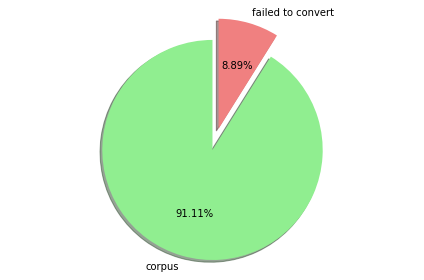

In [255]:
import matplotlib.pyplot as plt

labels = ['corpus', 'failed to convert']
sizes = [len(xmls)/len(results), (len(results)-len(xmls))/len(results)]

explode = (0, 0.2)

colors = ['#90EE90', '#F08080']

fig1, ax1 = plt.subplots()
ax1.pie(sizes, 
        explode=explode, 
        labels=labels, 
        colors=colors, 
        autopct='%1.2f%%', 
        shadow=True, 
        startangle=90)

ax1.axis('equal')

plt.tight_layout()
plt.show()

## 4. Can retrieve individual preprints from online or from the associated tar file:

This helped: https://jarrodmcclean.com/simple-bash-parallel-commands-in-python/

First I need to confirm the main file in each repository. 
- If it doesn't contain a .bbl file, I need to add it to the bbl_lack folder. Later. Set aside and skip.
- If it doesn't contain a file, I need to retrieve it again. Later. Set aside and skip. 

I will look at each submission folder, check xml to see if a file exists with its name. If not, I will go into the submission folder to check each file if it contains \\documentclass. If it does, grab it and convert it. Break out of loop. 

In [19]:
def guess_extension_from_headers(h):
    """
    Given headers from an ArXiV e-print response, try and guess what the file
    extension should be.
    Based on: https://arxiv.org/help/mimetypes
    """
    if h.get('content-type') == 'application/pdf':
        return '.pdf'
    if h.get('content-encoding') == 'x-gzip' and h.get('content-type') == 'application/postscript':
        return '.ps.gz'
    if h.get('content-encoding') == 'x-gzip' and h.get('content-type') == 'application/x-eprint-tar':
        return '.tar.gz'
    # content-encoding is x-gzip but this appears to normally be a lie - it's
    # just plain text
    if h.get('content-type') == 'application/x-eprint':
        return '.tex'
    if h.get('content-encoding') == 'x-gzip' and h.get('content-type') == 'application/x-dvi':
        return '.dvi.gz'
    return None

def arxiv_id_to_source_url(arxiv_id):
    # This URL is normally a tarball, but sometimes something else.
    # ArXiV provides a /src/ URL which always serves up a tarball,
    # but if we used this, we'd have to untar the file to figure out
    # whether it's renderable or not. By using the /e-print/ endpoint
    # we can figure out straight away whether we should bother rendering
    # it or not.
    # https://arxiv.org/help/mimetypes has more info
    return 'https://arxiv.org/e-print/' + arxiv_id

def download_source_file(arxiv_id):
    """
    Download the LaTeX source of this paper and returns as ContentFile.
    """
    source_url = arxiv_id_to_source_url(arxiv_id)
    res = requests.get(source_url)
    res.raise_for_status()
    extension = guess_extension_from_headers(res.headers)
    if not extension:
        raise DownloadError("Could not determine file extension from "
                            "headers: Content-Type: {}; "
                            "Content-Encoding: {}".format(
                                res.headers.get('content-type'),
                                res.headers.get('content-encoding')))
    downloaded_filename = '../data/temp_extractions/' + arxiv_id + extension
    with open(downloaded_filename, 'wb+') as f:
        f.write(res.content)
        print('Created ' + arxiv_id + extension)
    return downloaded_filename

#download_source_file('1010.3382')